# Experiment 1 - Minimum Balancing with 64x64 Resizing

This experiment consists on the pre-processing data pipeline established below:

- Data Balancing with Reduction + Oversampling, resulting in 2,100 training images as final dataset.
- Image Resizing to 64x64 in order to improve performance.
- Pixel Values Normalisation to range 0 to 1.

No further data augmentation was implemented during this experiment

## Initial Setup

This initial setup is used to allow direct import of classes from other Notebooks available on Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

## Libraries Import

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os

## Instances of the class

In [ ]:
db = DataBalancer()
dp = DataPreparer()
msp = ModelSpecificProcessor()
bm = BaseModel()

## Train Data Pre-Processing

### Capture and prepare labels data

In this step, the csv file containing diagnosis of lesion type is captured into a dataframe and transformed to provide labels in a single lesion type feature, encode categorical labels, and store image full path based on Google Drive folder structure.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = dp.labelPathMapper(df, 'train')
df.head()

,image,lesion_type,label_encoded,img_path
0,ISIC_0024306,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,MEL,1,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [ ]:
# Check for any issues with img_path
missing_files = [f for f in df['img_path'].values if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Example missing path:", missing_files[0])

Missing files: 0


### Data Balancing

For this experiment, the data balance consists of capturing n random samples of each category where n = the record count of the smallest lesion type in the dataset. Based on ISIC 2018 Train Dataset, as observed in file ISIC2018_Task3_Data_Analysis, this corresponds to lesion DF with 115 records.<br><br>
There are 7 categories, which when sampled to 115 per categories provides 805 records. This is insufficient data for training purposes, therefore oversampling is performed to achieve 300 images per categories, providing 2,100 records for training.

In [ ]:
ds_train = db.minBalancing(df)

### Image Resizing and Normalisation

In [ ]:
HEIGHT = 64
WIDTH = 64

def resize_wrapper(path, label):
    return dp.imageResizer(path, label, HEIGHT, WIDTH)

ds_train = ds_train.map(resize_wrapper)

In [ ]:
ds_train = ds_train.map(dp.pixelNormalizer)

In [ ]:
BATCH_SIZE = 32

# Update shape to match model Sequential.call() shape
ds_train = ds_train.batch(BATCH_SIZE)

## Validation and Test Data Pre-Processing

In [ ]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
df_validate = dp.labelPathMapper(df_validate, 'validate')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
df_test = dp.labelPathMapper(df_test, 'test')

In [ ]:
# Build image tensorflow dataset

ds_validate = db.buildDS(df_validate)
ds_test = db.buildDS(df_test)

In [ ]:
# Image resizing 64x64

ds_validate = ds_validate.map(resize_wrapper)
ds_test = ds_test.map(resize_wrapper)

In [ ]:
# Pixel values normalisation

ds_validate = ds_validate.map(dp.pixelNormalizer)
ds_test = ds_test.map(dp.pixelNormalizer)

In [ ]:
# Update shape to match model Sequential.call() shape

ds_validate = ds_validate.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

## Model Building, Training and Validating

In [ ]:
NUM_CLASSES = len(df.lesion_type.unique())
CHANNELS = 3
EPOCHS = 8

In [ ]:
# Function to support epoch plotting

def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# Build Base Models

# Custom CNN Model
custom_CNN = bm.customCNN()
# EfficientNet Models
base_modelENB0 = bm.modelENB0(HEIGHT,WIDTH)
base_modelENB4 = bm.modelENB4(HEIGHT,WIDTH)
base_modelENB7 = bm.modelENB7(HEIGHT,WIDTH)
base_modelENV2M = bm.modelENV2M(HEIGHT,WIDTH)
# ResNet Models
base_modelRN50V2 = bm.modelRN50V2(HEIGHT,WIDTH)
base_modelRN152V2 = bm.modelRN152V2(HEIGHT,WIDTH)
# Inception Model
base_modelINV3 = bm.modelINV3(HEIGHT,WIDTH)
# DenseNet Models
base_modelDN121 = bm.modelDN121(HEIGHT,WIDTH)
base_modelDN201 = bm.modelDN201(HEIGHT,WIDTH)

# Build custom Fully Connected Layer
custom_final_layer = bm.finaLayer(NUM_CLASSES)

### Custom CNN

In [1]:
modelCNN = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    custom_CNN,
])

modelCNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelCNN.summary()

NameError: name 'models' is not defined

In [ ]:
start_time = time.time()
histCNN = modelCNN.fit(ds_train, epochs=EPOCHS, validation_data=ds_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelCNN.evaluate(ds_validate)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histCNN, "Custom CNN")

### EfficientNet Models

EfficientNet is a family of Convolutional Neural Networks (CNNs) that scales up models using compound coefficient, which uniformally scales each dimension with fixed coefficients, simultaneously increasing width, depth, and resolution.

In [ ]:
ds_train_EN = ds_train.map(msp.efficientNetPrep)
ds_validate_EN = ds_validate.map(msp.efficientNetPrep)
ds_test_EN = ds_test.map(msp.efficientNetPrep)

#### EfficientNet-B0

In [ ]:
modelENB0 = models.Sequential([
    base_modelENB0,
    custom_final_layer,
])

modelENB0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
start_time = time.time()
histENB0 = modelENB0.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B0 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3797 - loss: 2.5176 - val_accuracy: 0.0415 - val_loss: 2.5663
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2100 - loss: 2.5256 - val_accuracy: 0.0155 - val_loss: 2.4018
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.0852 - loss: 2.0757 - val_accuracy: 0.0155 - val_loss: 2.0724
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 981ms/step - accuracy: 0.1781 - loss: 2.9236 - val_accuracy: 0.0052 - val_loss: 3.8192
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.2740 - loss: 2.1449 - val_accuracy: 0.0052 - val_loss: 25.6917
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 981ms/step - accuracy: 0.2696 - loss: 1.9608 - val_accuracy: 0.0155 - val_loss: 19.5003
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1636 - loss: 2.5330 - val_accuracy: 0.6373 - val_loss: 3.0055
Epoch 8/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5349 - loss: 1.7011 - val_accuracy: 0.0052 

In [ ]:
loss, accuracy = modelENB0.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

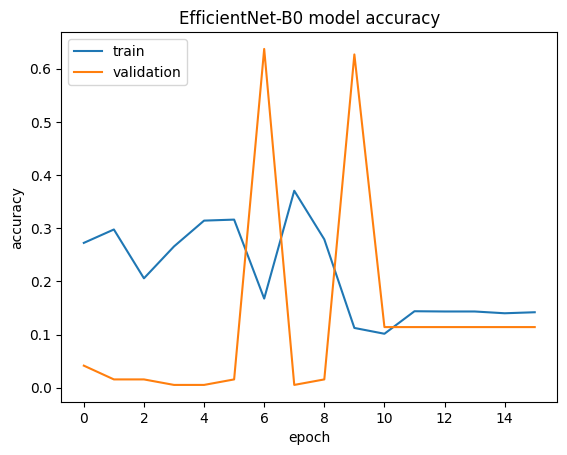

In [ ]:
plot_hist(histENB0, "EfficientNet-B0")

#### EfficientNet-B4

In [ ]:
modelENB4 = models.Sequential([
    base_modelENB4,
    custom_final_layer,
])

modelENB4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 2, 2, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,630 (69.18 MB)

 Trainable params: 18,009,423 (68.70 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
start_time = time.time()
histENB4 = modelENB4.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B4 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelENB4.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histENB4, "EfficientNet-B4")

#### EfficientNet-B7

In [ ]:
modelENB7 = models.Sequential([
    base_modelENB7,
    custom_final_layer,
])

modelENB7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB7.summary()

In [ ]:
start_time = time.time()
histENB7 = modelENB7.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B7 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelENB7.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histENB7, "EfficientNet-B7")

#### EfficientNetV2-M

In [ ]:
modelENV2M = models.Sequential([
    base_modelENV2M,
    custom_final_layer,
])

modelENV2M.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENV2M.summary()

In [ ]:
start_time = time.time()
histENV2M = modelENV2M.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNetV2-M Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelENV2M.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histENV2M, "EfficientNetV2-M")

### ResNet Models

In [ ]:
ds_train_RN = ds_train.map(msp.resNetPrep)
ds_validate_RN = ds_validate.map(msp.resNetPrep)
ds_test_RN = ds_test.map(msp.resNetPrep)

#### ResNet50V2

In [ ]:
modelRN50V2 = models.Sequential([
    base_modelRN50V2,
    custom_final_layer,
])

modelRN50V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN50V2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,143 (91.90 MB)

 Trainable params: 24,045,703 (91.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
start_time = time.time()
histRN50V2 = modelRN50V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet50V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.4675 - loss: 2.0388 - val_accuracy: 0.0777 - val_loss: 79.0152
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - accuracy: 0.0652 - loss: 1.9336 - val_accuracy: 0.0777 - val_loss: 4.1029
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 377s 6s/step - accuracy: 0.0883 - loss: 1.8392 - val_accuracy: 0.0777 - val_loss: 1.8768
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 389s 6s/step - accuracy: 0.1357 - loss: 1.8194 - val_accuracy: 0.1088 - val_loss: 2.5705
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 354s 5s/step - accuracy: 0.0132 - loss: 1.9650 - val_accuracy: 0.0052 - val_loss: 3.2678
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.3516 - loss: 1.6454 - val_accuracy: 0.0052 - val_loss: 2.7685
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.4305 - loss: 1.3488 - val_accuracy: 0.6373 - val_loss: 1.7384
Epoch 8/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.5454 - loss: 1.1808 - val_accuracy: 0.0155 - 

In [ ]:
loss, accuracy = modelRN50V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

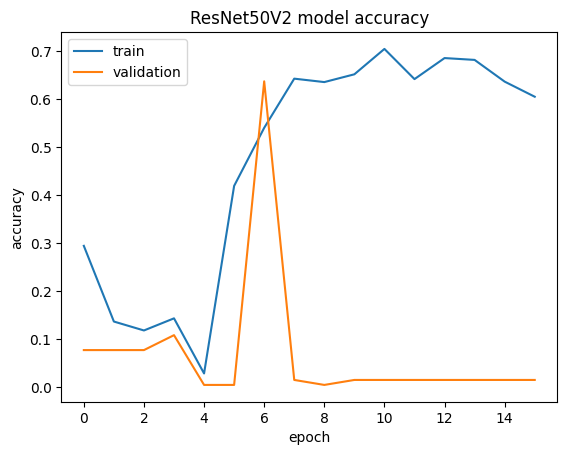

In [ ]:
plot_hist(histRN50V2, "ResNet50V2")

#### ResNet152V2

In [ ]:
modelRN152V2 = models.Sequential([
    base_modelRN152V2,
    custom_final_layer,
])

modelRN152V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN152V2.summary()

In [ ]:
start_time = time.time()
histRN152V2 = modelRN152V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet152V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelRN152V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histRN152V2, "ResNet152V2")

### Inception Models

In [ ]:
ds_train_IN = ds_train.map(msp.inceptionPrep)
ds_validate_IN = ds_validate.map(msp.inceptionPrep)
ds_test_IN = ds_test.map(msp.inceptionPrep)

#### InceptionV3

In [ ]:
modelINV3 = models.Sequential([
    base_modelINV3,
    custom_final_layer,
])

modelINV3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelINV3.summary()

In [ ]:
start_time = time.time()
histINV3 = modelINV3.fit(ds_train_IN, epochs=EPOCHS, validation_data=ds_validate_IN)
end_time = time.time()
duration = end_time - start_time
print(f"Model InceptionV3 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelINV3.evaluate(ds_validate_IN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histINV3, "InceptionV3")

### DenseNet Models

In [ ]:
ds_train_DN = ds_train.map(msp.denseNetPrep)
ds_validate_DN = ds_validate.map(msp.denseNetPrep)
ds_test_DN = ds_test.map(msp.denseNetPrep)

#### DenseNet121

In [ ]:
modelDN121 = models.Sequential([
    base_modelDN121,
    custom_final_layer,
])

modelDN121.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelDN121.summary()

In [ ]:
start_time = time.time()
histDN121 = modelDN121.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet121 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelDN121.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histDN121, "DenseNet121")

#### DenseNet201

In [ ]:
modelDN201 = models.Sequential([
    base_modelDN201,
    custom_final_layer,
])

modelDN201.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN201.summary()

In [ ]:
start_time = time.time()
histDN201 = modelDN201.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
loss, accuracy = modelDN201.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [ ]:
plot_hist(histDN201, "DenseNet201")